# Variational Autoencoder for STL Objects

The goal of this notebook is to produce a Variational Autoencoder (VAE) that can encode and then decode Voxel objects.

This VAE is based off of the implementation demonstrated in [this YouTube video](https://www.youtube.com/watch?v=LtpU1yBStlU) [github link](https://github.com/ajbrock/Generative-and-Discriminative-Voxel-Modeling/blob/master/Generative/VAE.py). We refer to this VAE as the "Example VAE" in this notebook.

Another good example: https://github.com/hiranumn/DLmodels/blob/master/voxel_modeling/3D-Conv-VAE%20implementation%20(ModelNet%20Chair%20example).ipynb

## Notes

* We still use Thingi10k as our data source. Thingi10k's objects are stl files, so we employ methods explored in stl_voxelization.ipynb to convert each stl file to binvox (a voxel format).
* The Example VAE is written in python with theano and lasagne
* Lasagne's Glorot Uniform initializer \[[docs](https://lasagne.readthedocs.io/en/latest/modules/init.html)\] is the same as Xavier Uniform initializer (Tensorflow's API [docs](https://www.tensorflow.org/api_docs/python/tf/glorot_uniform_initializer)).
* The encoder uses conv3d layers and the decoder uses conv3d_transpose layers; TF describes [here] (https://www.tensorflow.org/api_docs/python/tf/nn/conv3d_transpose) that conv3d_transpose is the opposite of conv3d.

## Env Setup

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import time
import os

import matplotlib.pyplot as plt
%matplotlib inline

# autoreload modules
%load_ext autoreload
%autoreload 2

# set seeds for reproducibility
np.random.seed(12)
tf.set_random_seed(12)

## Data Import

In [2]:
# import data
import env
from data.thingi10k import Thingi10k
from data.stl import save_vectors_as_stl, plot_mesh
from data.voxels import plot_voxels
from models import MODEL_DIR


#thingi = Thingi10k.init10k(pctile=.1)
# apply filter
#thingi.filter_by_tag('animal')
thingi = Thingi10k.init10()
thingi = Thingi10k.init10(pctile=.1)
n_samples = len(thingi)
n_samples

1

In [3]:
class VariationalAutoencoder():
    
    def __init__(self, input_dim, latent_dim, learning_rate, keep_prob, verbose=False, 
                 kl_div_loss_weight=5, recon_loss_weight=5e-4, ckpt_dir='voxel_vae'):
        """
        Args:
            kl_div_loss_weight: float, weight for KL Divergence loss when computing total loss
            recon_loss_weight: float, weight for reconstruction loss when computing total loss

        """
        # network and training params
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.learning_rate = learning_rate
        self.keep_prob = keep_prob
        self.verbose = verbose
        self.kl_div_loss_weight = kl_div_loss_weight
        self.recon_loss_weight = recon_loss_weight
        
        self._input_x = tf.placeholder(tf.float32, shape=(None, self.input_dim, self.input_dim, self.input_dim, 1))
        self._keep_prob = tf.placeholder(dtype=tf.float32)
        self._trainable = tf.placeholder(dtype=tf.bool)

        self.encoder, self.enc_mu, self.enc_sig = self._make_encoder(self._input_x, self._keep_prob, self._trainable)
        self.decoder = self._make_decoder(self.encoder, self._trainable)
        self.loss, self.optimizer, self.recon_loss, self.kl_divergence = self._make_loss(self._input_x, self.decoder, self.enc_mu, self.enc_sig)

        # Initializing the tensor flow variables
        init = tf.global_variables_initializer()
        
        # Setup Model Saving
        self.ckpt_dir = os.path.join(MODEL_DIR, ckpt_dir)
        self.saver = tf.train.Saver()
        self.recons = list()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
        
    def _print_shape(self, tensor, name=None):
        if self.verbose:
            if not name:
                name = tensor.name
            print('{}:'.format(name), tensor.shape)
        return
    
    def _make_encoder(self, input_x, keep_prob, trainable):
        
        # tf conv3d: https://www.tensorflow.org/api_docs/python/tf/layers/conv3d
        # tf glorot init: https://www.tensorflow.org/api_docs/python/tf/glorot_uniform_initializer
        conv1 = tf.layers.conv3d(input_x,
                                 filters=8,
                                 kernel_size=[3, 3, 3],
                                 strides=(1, 1, 1),
                                 padding='valid',
                                 #activation=tf.nn.elu,
                                 kernel_initializer=tf.initializers.glorot_uniform(),
                                 name='enc_conv1')
        self._print_shape(conv1)
        # the Example VAE specifies the activation functions as part of the layer
        # we specify the activation function as a seperate tensor
        # it is unknown if this is the preferred method in Tensorflow, but we know
        # it works from work in the 3D-VAE-GAN notebook
        # we also take advantage of batch_normalization
        # more info here:
        # https://medium.com/@ilango100/batch-normalization-speed-up-neural-network-training-245e39a62f85
        # with the hope that it gives speed without sacrificing quality
        # tf batch norm: https://www.tensorflow.org/api_docs/python/tf/layers/batch_normalization
        # tf elu (exponential linear unit): https://www.tensorflow.org/api_docs/python/tf/nn/elu
        lrelu1 = tf.nn.elu(tf.layers.batch_normalization(conv1, training=trainable), name='enc_lrelu1')
        self._print_shape(lrelu1)

        conv2 = tf.layers.conv3d(lrelu1,
                                 filters=16,
                                 kernel_size=[3, 3, 3],
                                 strides=(2, 2, 2),
                                 padding='same',
                                 kernel_initializer=tf.initializers.glorot_uniform(),
                                 name='enc_conv2')
        self._print_shape(conv2)
        lrelu2 = tf.nn.elu(tf.layers.batch_normalization(conv2, training=trainable), name='enc_lrelu2')
        self._print_shape(lrelu2)

        conv3 = tf.layers.conv3d(lrelu2,
                                 filters=32,
                                 kernel_size=[3, 3, 3],
                                 strides=(1, 1, 1),
                                 padding='valid',
                                 kernel_initializer=tf.initializers.glorot_uniform(),
                                 name='enc_conv3')
        self._print_shape(conv3)
        lrelu3 = tf.nn.elu(tf.layers.batch_normalization(conv3, training=trainable), name='enc_lrelu3')
        self._print_shape(lrelu3)
        
        conv4 = tf.layers.conv3d(lrelu2,
                                 filters=64,
                                 kernel_size=[3, 3, 3],
                                 strides=(2, 2, 2),
                                 padding='same',
                                 kernel_initializer=tf.initializers.glorot_uniform(),
                                 name='enc_conv4')
        self._print_shape(conv4)
        lrelu4 = tf.nn.elu(tf.layers.batch_normalization(conv4, training=trainable), name='enc_lrelu4')
        self._print_shape(lrelu4)
        
        # Apply one fully-connected layer after Conv3d layers
        # tf dense layer: https://www.tensorflow.org/api_docs/python/tf/layers/dense
        dense1 = tf.layers.dense(lrelu4,
                                 units=343,
                                 kernel_initializer=tf.initializers.glorot_uniform(),
                                 name='enc_dense1')
        self._print_shape(dense1)
        network_output = tf.nn.elu(tf.layers.batch_normalization(dense1, training=trainable), name='enc_lrelu5')
        self._print_shape(network_output)
        
        # apply dropout to prevent overtraining
        # why do we flatten?
        enc_output = tf.layers.flatten(tf.nn.dropout(network_output, keep_prob), name='enc_output')
        self._print_shape(enc_output)
        
        # transform the network output into the latent vector
        z_mu = tf.layers.dense(enc_output,
                         units=self.latent_dim,
                         # Example VAE does not use an initializer here
                         #kernel_initializer=tf.initializers.glorot_uniform(),
                         name='enc_mu')
        self._print_shape(z_mu)

        # Example VAE uses a custom layer to extract sigma
        # Here we borrow sigma calc from 3D-VAE-GAN
        z_sig = 0.5 * tf.layers.dense(enc_output, units=self.latent_dim, name='enc_sig')
        self._print_shape(z_sig, 'enc_sig')
        
        # epsilon is a random draw from the latent space
        epsilon = tf.random_normal(tf.stack([tf.shape(enc_output)[0], self.latent_dim]))
        self._print_shape(epsilon, 'epsilon')
        z = z_mu + tf.multiply(epsilon, tf.exp(z_sig))
        self._print_shape(z, 'z')
        
        return z, z_mu, z_sig
    
    def _make_decoder(self, input_z, trainable):
        
        # There is some magic in the Example VAE that adds conditional input based on the
        # class of the image. We do not have that luxury as we are attempting to do this
        # with input that lacks classes.
        # TODO: if poor results, try classes
        self._print_shape(input_z, 'input_z')

        # Why conv3d_transpose instead of conv3d?
        #
        # from https://www.tensorflow.org/api_docs/python/tf/nn/conv3d_transpose,
        #     "This operation is sometimes called "deconvolution" after Deconvolutional Networks,
        #      but is actually the transpose (gradient) of conv3d rather than an actual deconvolution."
        #
        # conv3d_transpose: https://www.tensorflow.org/api_docs/python/tf/layers/conv3d_transpose
        dense1 = tf.layers.dense(input_z,
                                 units=343,
                                 kernel_initializer=tf.initializers.glorot_uniform(),
                                 name='dec_dense1')
        self._print_shape(dense1)
        lrelu1 = tf.nn.elu(tf.layers.batch_normalization(dense1, training=trainable))
        self._print_shape(lrelu1)

        #z = tf.reshape(z, (-1, 1, 1, 1, n_latent))
        reshape_z = tf.reshape(lrelu1, shape=(-1, 7, 7, 7, 1), name='reshape_z')
        self._print_shape(reshape_z)
        #print('reshape_z: ', reshape_z.shape)
        #for value in reshape_z.shape:
        #    print(type(value))

        conv1 = tf.layers.conv3d_transpose(reshape_z,
                                           filters=64,
                                           kernel_size=[3, 3, 3],
                                           strides=(1, 1, 1),
                                           padding='same',
                                           # Example VAE does not mention bias
                                           use_bias=False,
                                           kernel_initializer=tf.initializers.glorot_uniform(),
                                           name='dec_conv1')
        self._print_shape(conv1)
        lrelu2 = tf.nn.elu(tf.layers.batch_normalization(conv1, training=trainable), name='dec_lrelu2')
        self._print_shape(lrelu2)

        conv2 = tf.layers.conv3d_transpose(lrelu2,
                                           filters=32,
                                           kernel_size=[3, 3, 3],
                                           # Example VAE used .5 stride values, but Tensorflow complains
                                           # of being forced to use a float value here
                                           #strides=(1.0 / 2, 1.0 / 2, 1.0 / 2),
                                           strides=(2, 2, 2),
                                           padding='same',
                                           use_bias=False,
                                           kernel_initializer=tf.initializers.glorot_uniform(),
                                           name='dec_conv2')
        self._print_shape(conv2)
        lrelu3 = tf.nn.elu(tf.layers.batch_normalization(conv2, training=trainable), name='dec_lrelu3')
        self._print_shape(lrelu3)

        conv3 = tf.layers.conv3d_transpose(lrelu3,
                                           filters=16,
                                           kernel_size=[3, 3, 3],
                                           strides=(1, 1, 1),
                                           # changed to valid to hit correct dimension
                                           padding='valid',
                                           use_bias=False,
                                           kernel_initializer=tf.initializers.glorot_uniform(),
                                           name='dec_conv3')
        self._print_shape(conv3)
        lrelu4 = tf.nn.elu(tf.layers.batch_normalization(conv3, training=trainable), name='dec_lrelu4')
        self._print_shape(lrelu4)

        conv4 = tf.layers.conv3d_transpose(lrelu4,
                                           filters=8,
                                           kernel_size=[4, 4, 4],
                                           #strides=(1.0 / 2, 1.0 / 2, 1.0 / 2),
                                           strides=(2, 2, 2),
                                           padding='same',
                                           use_bias=False,
                                           kernel_initializer=tf.initializers.glorot_uniform(),
                                           name='dec_conv4')
        self._print_shape(conv4)
        lrelu5 = tf.nn.elu(tf.layers.batch_normalization(conv4, training=trainable), name='dec_lrelu5')
        self._print_shape(lrelu5)

        conv5 = tf.layers.conv3d_transpose(lrelu4,
                                           filters=1,
                                           kernel_size=[3, 3, 3],
                                          # changed to 2 to hit correct dimension
                                           strides=(2, 2, 2),
                                           padding='same',
                                           use_bias=False,
                                           kernel_initializer=tf.initializers.glorot_uniform(),
                                           name='dec_conv5')
        self._print_shape(conv5)
        #decoded_output = tf.nn.tanh(conv5)
        decoded_output = tf.nn.sigmoid(conv5)
        #decoded_output = conv5
        self._print_shape(decoded_output)
        
        return decoded_output
    
    def _make_loss(self, enc_input, dec_output, z_mu, z_sig):
        """
        Info on loss in VAE:
          * https://stats.stackexchange.com/questions/332179/how-to-weight-kld-loss-vs-reconstruction-loss-in-variational-auto-encoder
          
        Args:
            enc_input: tensor, input tensor into VAE
            dec_output: tensor, decoded output tensor from VAE

        Return:
            float, 
        """
        
        # Weighted binary cross-entropy for use in voxel loss. Allows weighting of false positives relative to false negatives.
        # Nominally set to strongly penalize false negatives
        clipped_input = tf.clip_by_value(tf.nn.sigmoid(enc_input), 1e-7, 1.0 - 1e-7)
        bce = -(98.0 * clipped_input * tf.log(dec_output) + 2.0 * (1.0 - clipped_input) * tf.log(1.0 - dec_output)) / 100.0
        #bce = tf.keras.backend.binary_crossentropy(enc_output, dec_output)
        
        # Voxel-Wise Reconstruction Loss 
        # Note that the output values are clipped to prevent the BCE from evaluating log(0).
        recon_loss = tf.reduce_mean(bce)
   
        #recon_loss = tf.reduce_sum(tf.squared_difference(
        #    tf.reshape(dec_output, (-1, self.input_dim ** 3)),
        #    tf.reshape(self._input_x, (-1, self.input_dim ** 3))), 1)
        
        kl_divergence = -0.5 * tf.reduce_sum(1.0 + 2.0 * z_sig - z_mu ** 2 - tf.exp(2.0 * z_sig), 1)

        mean_KL = tf.reduce_sum(kl_divergence)
        mean_recon = tf.reduce_sum(recon_loss)

        # tf reduce_mean: https://www.tensorflow.org/api_docs/python/tf/math/reduce_mean
        loss = tf.reduce_mean(self.kl_div_loss_weight * kl_divergence + self.recon_loss_weight * recon_loss)
        
        optimizer = tf.train.RMSPropOptimizer(learning_rate=self.learning_rate).minimize(loss)

        return loss, optimizer, recon_loss, kl_divergence
        
    def train(self, generator, epochs=10, input_repeats=1, display_step=1, save_step=1):
        
        start = time.time()
        for epoch_num, epoch in enumerate(range(epochs)):

            for batch_num, batch in enumerate(generator()):
                
                #print('Epoch: {}, Batch: {}'.format(epoch_num, batch_num))
                #print("batch.min()", batch.min())
                #print("batch.max()", batch.max())
                # repeat for extra practice on each shape
                for _ in range(input_repeats):

                    _, loss, kl_divergence, recon_loss = self.sess.run(
                        (self.optimizer, self.loss, self.kl_divergence, self.recon_loss),
                        feed_dict={self._input_x: batch, self._keep_prob:self.keep_prob, self._trainable: True}
                    )
                
            if (epoch + 1) % display_step == 0:
                print("Epoch: {}, ".format(epoch + 1) + 
                      "Loss = {:.5f}, ".format(loss) + 
                      "KL Divergence = {:.5f}, ".format(kl_divergence[0]) +
                      #"Reconstruction Loss = {:.5f}, ".format(recon_loss[0]) +
                      "Reconstruction Loss = {:.5f}, ".format(recon_loss) +
                      "Elapsed time: {:.2f} mins".format((time.time() - start) / 60))
                print('Generation Example:')
                
                # prepare for generation
                #print(batch[0][0])
                self._print_shape(batch[0], 'Example shape (before reshape)')
                recon_input = np.reshape(batch[0], (1, self.input_dim, self.input_dim, self.input_dim, 1))
                self._print_shape(recon_input, 'Example shape')
                
                # generate!
                recon = self.reconstruct(recon_input)
                self._print_shape(recon, 'Recon')

                # prepare for plotting
                recon_input = np.reshape(recon_input, (self.input_dim, self.input_dim, self.input_dim))
                self._print_shape(recon_input, 'Example shape (for plotting)')
                recon = np.reshape(recon, (self.input_dim, self.input_dim, self.input_dim))
                self._print_shape(recon, 'Recon (for plotting)')
                # network outputs decimals; here we force them to True/False for plotting
                recon = recon > 0.5
                # replace all nans with zeros
                #recon = np.nan_to_num(recon)
                
                # save the generated object in case we wish to review later
                path = os.path.join(self.ckpt_dir, 'recon_epoch-{}.npy'.format(epoch))
                self.recons.append(recon)

                # visualize
                self.visualize_reconstruction(recon_input, recon)

            if (epoch + 1) % save_step == 0:
                # Save the variables to disk.
                save_path = self.saver.save(self.sess, os.path.join(self.ckpt_dir, "model_epoch-{}.ckpt".format(epoch)))
                print("Model saved in path: {}".format(save_path))
                                       
        return

    def restore(self, model_ckpt):
        self.saver.restore(self.sess, model_ckpt)
        return
    
    def close(self):
        self.sess.close()
        return
            
    def reconstruct(self, input_x):
        """
        Use VAE to reconstruct given data
        """
        decoded = self.sess.run(self.decoder, 
            feed_dict={self._input_x: input_x, self._keep_prob: 1.0, self._trainable: False})
        return decoded
    
    def visualize_reconstruction(self, original_x, reconstructed_x, name=None):
        title = '' if not name else ': {}'.format(name)
        plot_voxels(original_x, title='Original' + title)
        plot_voxels(reconstructed_x, title='Autoencoded' + title)
        return

    def __repr__(self):
        return '<VariationalAutoencoder(input_dim={}, latent_dim={}, learning_rate={}, keep_prob={})>'.format(
            self.input_dim, self.latent_dim, self.learning_rate, self.keep_prob)


## Training

The model is having issues producing an output that is recognizable.

Experiments:
* Large & small datasets produce the same result
* latent_dim variations have no effect
* Too high of a learning rate causes the loss to go down then up and sometimes fluctuate
* Removing dropout (keep_prob=1.0) with lr=0.00001 on a single training example causes loss to go down as expected but output is still not recognizable
* Upping recon_loss_weight seems to cause more variation in decoded output
* Severe upping of recon_loss_weight (recon=5, kl=5e-4) delivered loss of ~5 after 500 epochs on a single training example with 20 input_repeats
* 500 epochs with above settings and RMSPropOptimizer achieved loss of <1 after about 200 epochs; viz still unimpressive
* Increasing recon_loss_weight to 5e5 and dumping recon loss and kl divergence values reveals that recon loss is diminishing. Question: what is the input to recon loss? an array of 1s and 0s or TRUEs and FALSEs? A: 1s and 0s
* Using weight binary cross entropy for recon loss as according to Example VAE shows same loss reduction pattern with still unimpressive recon

Epoch: 50, Loss = 175.08426, KL Divergence = 175.03168, Reconstruction Loss = 0.05259, Elapsed time: 5.20 mins
Generation Example:


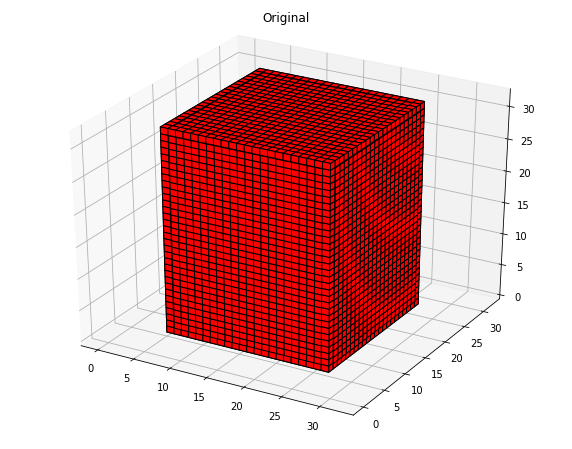

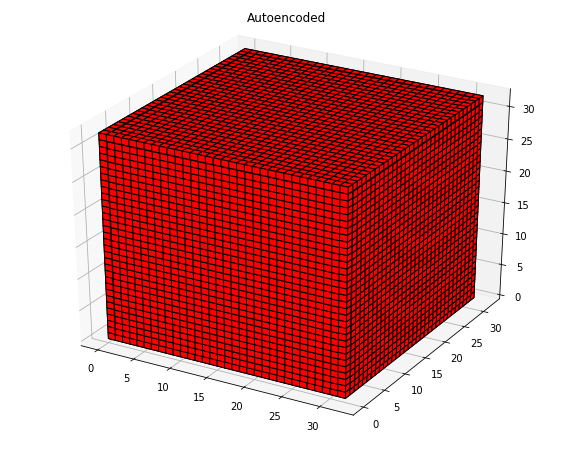

Epoch: 100, Loss = 29.23794, KL Divergence = 29.19707, Reconstruction Loss = 0.04087, Elapsed time: 10.52 mins
Generation Example:


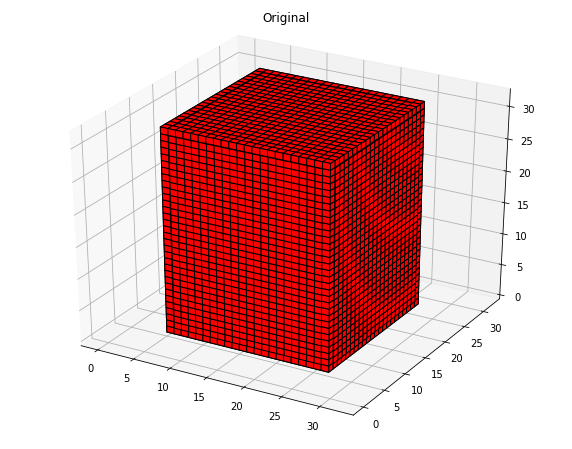

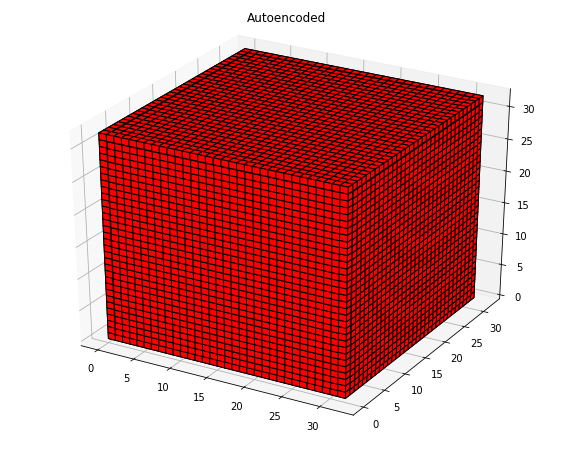

Model saved in path: /home/jcworkma/jack/3d-form/src/../models/voxel_vae/model_epoch-99.ckpt
Epoch: 150, Loss = 121.39606, KL Divergence = 121.35521, Reconstruction Loss = 0.04085, Elapsed time: 15.84 mins
Generation Example:


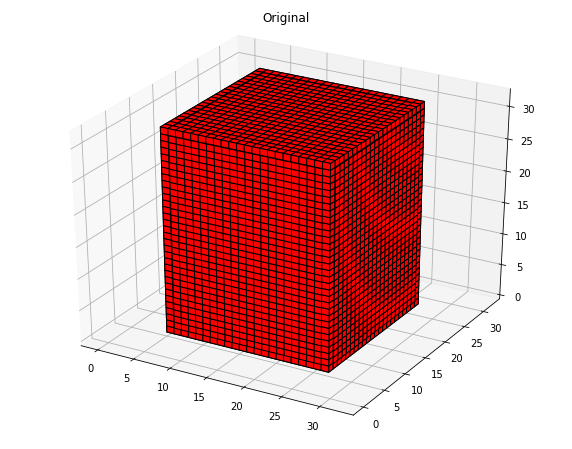

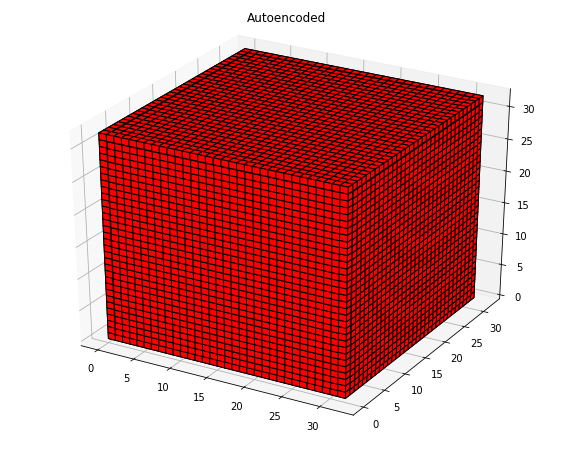

In [ ]:
tf.reset_default_graph()
VOXELS_DIM = 32
BATCH_SIZE = 1

try:
    vae = VariationalAutoencoder(input_dim=VOXELS_DIM,
                                 latent_dim=200,
                                 learning_rate=0.0001,
                                 keep_prob=1.0,
                                 kl_div_loss_weight=1,
                                 recon_loss_weight=1,
                                 verbose=False)

    generator = lambda: thingi.voxels_batchmaker(batch_size=BATCH_SIZE, voxels_dim=VOXELS_DIM, verbose=False)

    vae.train(generator, epochs=500, input_repeats=50, display_step=50, save_step=100)
except Exception as exc:
    vae.close()
    raise(exc)

In [ ]:
for i, recon in enumerate(vae.recons):
    print('--------------')
    print(i)
    print(recon.max())
    print(recon.min())


In [ ]:
plot_voxels(np.around(vae.recons[1]))

In [ ]:
# what does a voxel array of nans look like when plotted?
x = np.zeros((32, 32, 32))
#x.fill(np.nan)
x[0][0][0] = 1
plot_voxels(x)


In [ ]:
from data.voxels import read_voxel_array
path = '/home/jcworkma/jack/3d-form/src/../data/processed/Thingi10k/voxels/32/1131717.binvox'
read_voxel_array(path).dims

In [ ]:
x = np.fromtxt('/home/jcworkma/jack/3d-form/src/../models/voxel_vae/recon_epoch-0.npy')
print(x.max())